<a href="https://colab.research.google.com/github/cooooooky/DL/blob/main/ex02_MLP_%ED%95%99%EC%8A%B5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.autograd import Variable
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

## 1. MNIST train, test dataset 가져오기

In [ ]:
mnist_train=dset.MNIST("", train=True, transform=transforms.ToTensor(), target_transform=None, download=True)
mnist_test=dset.MNIST("", train=False, transform=transforms.ToTensor(), target_transform=None, download=True)

## 2. 대략적인 데이터 형태

mnist_train 길이: 60000
mnist_test  길이: 10000
image data 형태: torch.Size([1, 28, 28])
label:  5


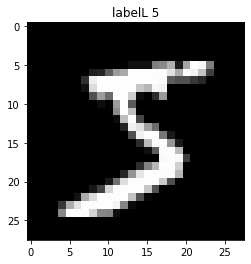

In [ ]:
print ("mnist_train 길이:", len(mnist_train))
print ("mnist_test  길이:", len(mnist_test))

# 데이터 하나 형태
image, label = mnist_train.__getitem__(0) # 0번째 데이터
print ("image data 형태:", image.size())
print ("label: ", label)

# 그리기
img = image.numpy() # image 타입을 numpy 로 변환 (1,28,28)
plt.title("labelL %d" %label)
plt.imshow(img[0], cmap='gray')
plt.show()

## 3. 데이터 로드함수
#### 학습시킬 때 batch_size 단위로 끊어서 로드하기 위함

In [ ]:
# hyper parameters
batch_size = 1024
learning_rate = 0.01
num_epoch = 400

# mnist를 트레인 시키자. 결과를 일관적으로 확인할 필요가 있음->test data는 셔플 x. batch_size만큼 나눌 때 나머지는 버려라.
train_loader = torch.utils.data.DataLoader(mnist_train, batch_size=batch_size, shuffle=True, num_workers=2, drop_last=True)
test_loader = torch.utils.data.DataLoader(mnist_test, batch_size=batch_size, shuffle=False, num_workers=2, drop_last=True)

### 데이터 로드함수 이해하기

[0]
한 번에 로드되는 데이터 크기: 1024


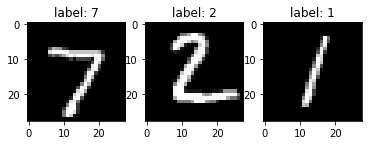

[1]
한 번에 로드되는 데이터 크기: 1024


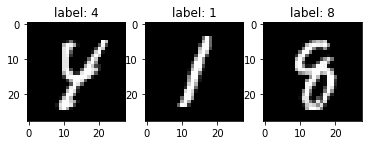

[2]
한 번에 로드되는 데이터 크기: 1024


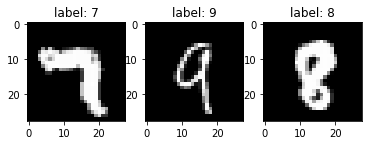

[3]
한 번에 로드되는 데이터 크기: 1024


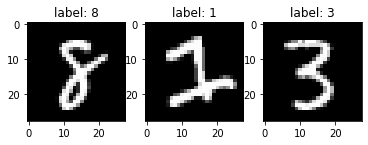

[4]
한 번에 로드되는 데이터 크기: 1024


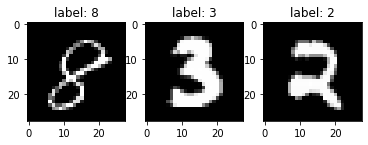

[5]
한 번에 로드되는 데이터 크기: 1024


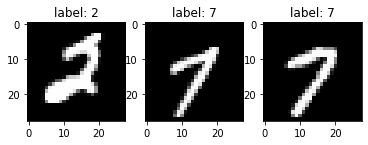

In [ ]:
n=3 # 샘플로 그려볼 데이터 개수
for i, [imgs, labels] in enumerate(test_loader): # batch_size 만큼
    if i>5:
        break
    print ("[%d]" %i)
    print ("한 번에 로드되는 데이터 크기:", len(imgs))
    for j in range(n): # 그리기
        img = imgs[j].numpy() # image 타입을 numpy로 변환
        img = img.reshape((img.shape[1], img.shape[2])) # (1,28,28)->(28,28)
        
        plt.subplot(1, n, j+1) # (1,3) 형태 플랏의 j번째 자리에 그리겠다
        plt.imshow(img, cmap='gray')
        plt.title("label: %d" %labels[j])
    plt.show()

## 4. 모델 선언

In [ ]:
model = nn.Sequential( # 퍼셉트론(2 hidden layer)
    nn.Linear(28*28, 256), nn.Sigmoid(), ##nn.ReLu(), nn.Sigmoid() 91.89%
    nn.Linear(256,128),
    nn.Linear(128,10),
)

#print(list(model.parameters())) # 초기 파라미터 출력
model = model.cuda()

### 정확도 계산 함수

In [ ]:
def ComputeAccr(dloader, imodel):
    correct = 0
    total = 0
    for j, [imgs, labels] in enumerate(dloader): # batch_size 만큼 (9번 반복)
        img = imgs # x
        label = Variable(labels).cuda() # y
        
        img = img.reshape((img.shape[0], img.shape[2], img.shape[3])) # (batch_size, 1, 28, 28)->(batch_size, 28, 28)
        img = img.reshape((img.shape[0], img.shape[1]*img.shape[2])) # (batch_size, 28, 28) -> (batch_size, 28*28)
        img = Variable(img, requires_grad=False).cuda() # https://dororongju.tistory.com/142
        
        output = imodel(img) # forward propagation
        _, output_index = torch.max(output, 1)
        
        total += label.size(0) # 1024씩 9번 더함
        correct += (output_index == label).sum().float()
    print("Accuracy of Test Data: {}".format(100*correct/total))

In [ ]:
ComputeAccr(test_loader, model)

Accuracy of Test Data: 10.188801765441895


## 5. loss, optimizer

In [ ]:
loss_func = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

## 6. 학습

In [ ]:
num_epoch = 400
for i in range(num_epoch):
    for j, [imgs, labels] in enumerate(train_loader): # batch_size 만큼
        img = imgs # (batch_size, 1, 28, 28)
        label = Variable(labels).cuda() # (batch_size)
        
        img = img.reshape((img.shape[0], img.shape[2], img.shape[3])) # (batch_size, 1, 28, 28)->(batch_size, 28, 28)
        img = img.reshape((img.shape[0], img.shape[1]*img.shape[2])) # (batch_size, 28, 28) -> (batch_size, 28*28)
        img = Variable(img, requires_grad=True).cuda() # 위 3줄은 정확도 계산 함수 부분과 동일. require_grad는 True.
        
        optimizer.zero_grad()
        output = model(img) # forward prop.
        loss = loss_func(output, label) # logit, target(1)
        loss.backward() # back prop.
        optimizer.step() # weight 업데이트
        
    if i%50==0:
        print("%d.." %i)
        ComputeAccr(test_loader, model)
        print(loss)

0..
Accuracy of Test Data: 16.09157943725586
tensor(2.2957, device='cuda:0', grad_fn=<NllLossBackward0>)
50..
Accuracy of Test Data: 81.42361450195312
tensor(0.6496, device='cuda:0', grad_fn=<NllLossBackward0>)
100..
Accuracy of Test Data: 88.12934112548828
tensor(0.4410, device='cuda:0', grad_fn=<NllLossBackward0>)
150..
Accuracy of Test Data: 89.68099212646484
tensor(0.3681, device='cuda:0', grad_fn=<NllLossBackward0>)
200..
Accuracy of Test Data: 90.4296875
tensor(0.3353, device='cuda:0', grad_fn=<NllLossBackward0>)
250..
Accuracy of Test Data: 91.06987762451172
tensor(0.2885, device='cuda:0', grad_fn=<NllLossBackward0>)
300..
Accuracy of Test Data: 91.48220825195312
tensor(0.3042, device='cuda:0', grad_fn=<NllLossBackward0>)
350..
Accuracy of Test Data: 91.796875
tensor(0.3260, device='cuda:0', grad_fn=<NllLossBackward0>)


## 7. 테스트

In [ ]:
ComputeAccr(test_loader, model)

Accuracy of Test Data: 91.98133850097656


## 8. 학습된 파라미터 저장

In [57]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [60]:
netname = '/content/gdrive/My Drive/Colab Notebooks/nets/mlp_weight.pkl'
torch.save(model, netname, )